# Tutorial 4: Optimization Introduction

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
from spectpsftoolbox import simind_io
from spectpsftoolbox.operator2d import GaussianOperator, Kernel2DOperator
from spectpsftoolbox.kernel2d import NGonKernel2D
from spectpsftoolbox.utils import get_kernel_meshgrid
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.manual_seed(0)

In the 3rd tutorial we created a model for the PSF expected in SPECT imaging from a collimator with hole length 2.405cm, width 0.254cm, acquiring photons of energy 140.5keV, with an intrinsic scintillator crystal resolution of  0.38cm.

In this tutorial, we'll open some real Monte Carlo data corresponding to the configuration above and compare it to our model. We'll then use ADAM optimization to adjust the parameters of our model so that the PSF model better approximates the data (in reality, things like collimator scatter change the shape of the PSF).

First we'll open the Monte Carlo data

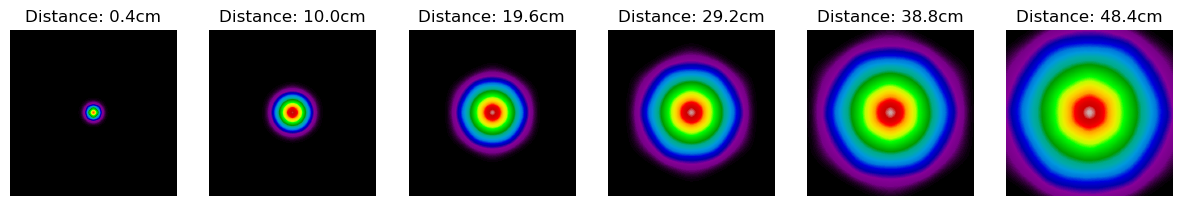

In [6]:
headerpaths = np.array([f'/disk1/psf_data/140keV_UHS_PSF/point_position{i}_tot_w1.h00' for i in range(60,181)])
respaths = np.array([f'/disk1/psf_data/140keV_UHS_PSF/point_position{i}.res' for i in range(60,181)])
distances = simind_io.get_source_detector_distances(respaths).to(device)
projectionss_data = simind_io.get_projections(headerpaths).to(device)

# Normalize the projections data:
projectionss_data /= projectionss_data.sum(dim=(1,2)).mean()

# Plot projections data
fig, ax = plt.subplots(1, 6, figsize=(15,3))
for i, IDX in enumerate([0,20,40,60,80,100]):
    ax[i].set_title(f'Distance: {distances[IDX].cpu():.1f}cm')
    ax[i].imshow(projectionss_data.cpu()[IDX], cmap='nipy_spectral', interpolation='gaussian')
    ax[i].axis('off')
    ax[i].set_xlim(256-20, 256+20); ax[i].set_ylim(256-20, 256+20)

The dimensions of this Monte Carlo data 

Now let's recreate our PSF operator from tutorial 3

In [7]:
# -------------------
# Collimator Component
# -------------------

collimator_length = 2.405 
collimator_width = 0.254 #flat side to flat side
mu = 28.340267562430935
sigma_fn = lambda a, bs: (bs[0]+a) / bs[0] 
sigma_params = torch.tensor([collimator_length-2/mu], requires_grad=True, dtype=torch.float32, device=device)
# Set amplitude to 1
amplitude_fn = lambda a, bs: torch.ones_like(a)
amplitude_params = torch.tensor([1.], requires_grad=True, dtype=torch.float32, device=device)

ngon_kernel = NGonKernel2D(
    N_sides = 6, # sides of polygon
    Nx = 255, # resolution of polygon
    collimator_width=collimator_width, # width of polygon
    amplitude_fn=amplitude_fn,
    sigma_fn=sigma_fn,
    amplitude_params=amplitude_params,
    sigma_params=sigma_params,
    rot=90
)
ngon_operator = Kernel2DOperator(ngon_kernel)

# -------------------
# Detector component
# -------------------

intrinsic_sigma = 0.1614 # typical for NaI 140keV detection
gauss_amplitude_fn = lambda a, bs: torch.ones_like(a)
gauss_sigma_fn = lambda a, bs: bs[0]*torch.ones_like(a)
gauss_amplitude_params = torch.tensor([1.], requires_grad=True, dtype=torch.float32, device=device)
gauss_sigma_params = torch.tensor([intrinsic_sigma], requires_grad=True, device=device, dtype=torch.float32)
scint_operator = GaussianOperator(
    gauss_amplitude_fn,
    gauss_sigma_fn,
    gauss_amplitude_params,
    gauss_sigma_params,
)

# Total combined:
psf_operator = scint_operator * ngon_operator

/data/anaconda/envs/pytomo_install_test/lib/python3.11/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/data/anaconda/envs/pytomo_install_test/lib/python3.11/site-packages/torchquad/integration/utils.py:255: UserWarning: DEPRECATION WARNING: In future versions of torchquad, an array-like object will be returned.
  warnings.warn(


...and apply it to some input:

In [8]:
# Get meshgrid corresponding to SIMIND sim dimensions
xv, yv = simind_io.get_meshgrid(respaths, device=device)
# Get kernel meshgrid
k_width = 24 #cm
xv_k, yv_k = get_kernel_meshgrid(xv, yv, k_width)
# Create input with point source at origin
input = torch.zeros_like(xv).unsqueeze(0).repeat(distances.shape[0], 1, 1)
input[:,256,256] = 1
output = psf_operator(input, xv_k, yv_k, distances, normalize=True)

...and compare to the Monte Carlo

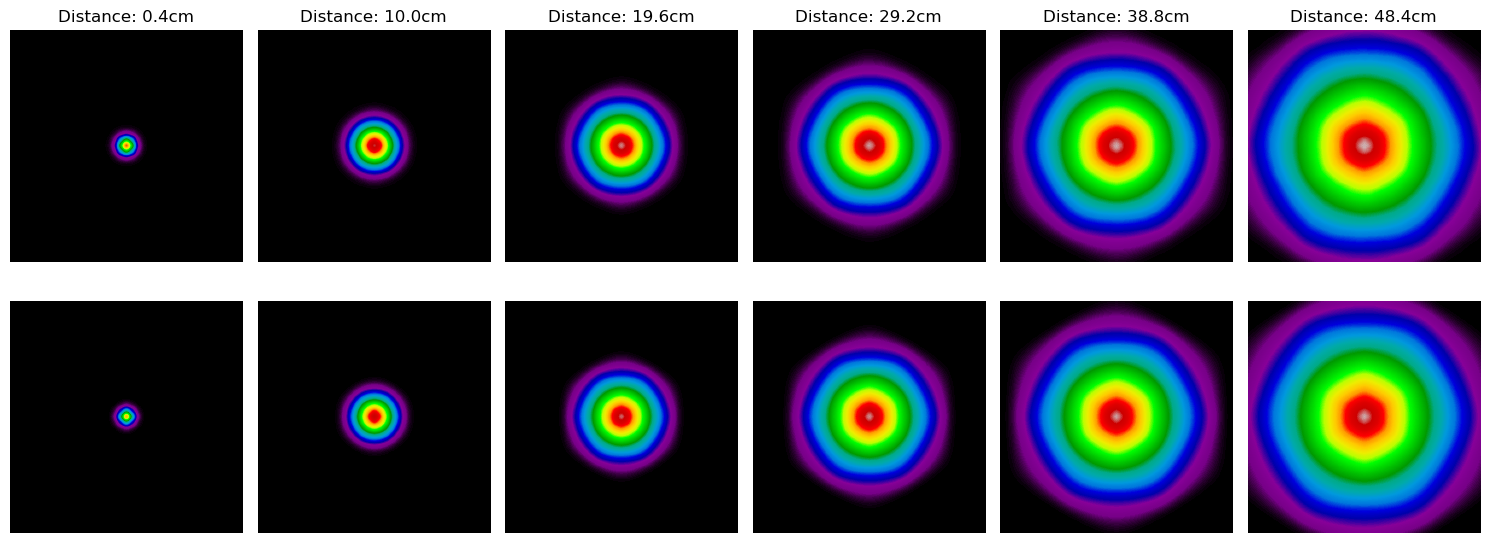

In [9]:
# Plot projections data
fig, ax = plt.subplots(2, 6, figsize=(15,6))
for i, IDX in enumerate([0,20,40,60,80,100]):
    ax[0,i].set_title(f'Distance: {distances[IDX].cpu():.1f}cm')
    ax[0,i].imshow(projectionss_data.cpu()[IDX], cmap='nipy_spectral', interpolation='gaussian')
    ax[1,i].imshow(output.detach().cpu()[IDX], cmap='nipy_spectral', interpolation='gaussian')
[a.axis('off') for a in ax.ravel()]
[a.set_xlim(256-20, 256+20) for a in ax.ravel()]
[a.set_ylim(256-20, 256+20) for a in ax.ravel()]
fig.tight_layout()
plt.show()

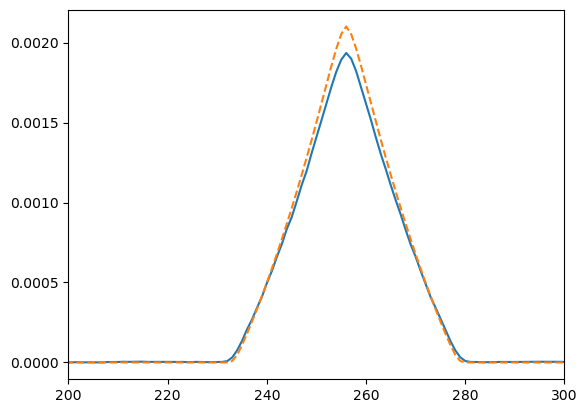

In [10]:
IDX = 100
plt.plot(projectionss_data[IDX,255].cpu())
plt.plot(output[IDX,255].detach().cpu(), ls='--')
plt.xlim(200,300)
plt.show()

The results are close but don't quite match. We can adjust the two parameters (`gauss_sigma_params` and `sigma_params` of NGon kernel) as follows using standard pytorch optimization:

In [11]:
def loss_fn(psf_pred, psf_data):
    return torch.sum((psf_pred - psf_data)**2)  

def train_w(operator, n_iters, lr=1e-3):
    optimizer = optim.Adam([*operator.params], lr=lr)
    for _ in range(n_iters):
        optimizer.zero_grad()
        error = loss_fn(operator(input,xv_k,yv_k,distances,normalize=True),projectionss_data)
        print(error.item(), end="\r")
        error.backward()
        optimizer.step()
        
train_w(psf_operator, n_iters=40, lr=4e-3)

Lets get the new output and plot:

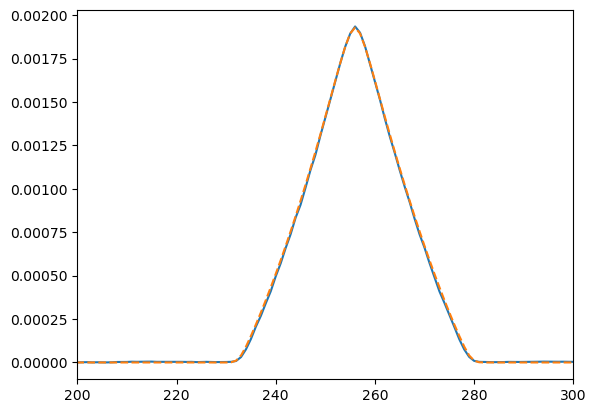

In [12]:
output_new = psf_operator(input, xv_k, yv_k, distances, normalize=True)
IDX = 100
plt.plot(projectionss_data[IDX,255].cpu())
plt.plot(output_new[IDX,255].detach().cpu(), ls='--')
plt.xlim(200,300)
plt.show()

Looks good! We can also select a new input with new spacing and evaluate the kernel, and check that its normalized

In [13]:
# Typical size and spacing for SPECT reconstruction:
Nx = 128
dx = 0.48
x = torch.arange(-Nx//2, Nx//2, 1).to(device)*dx
y = torch.arange(-Nx//2, Nx//2, 1).to(device)*dx
xv, yv = torch.meshgrid(x, y, indexing='xy')
input128 = torch.zeros((distances.shape[0], Nx, Nx), device=device)
input128[:,64,64] = 1

k_width = 24 #cm
xv_k, yv_k = get_kernel_meshgrid(xv, yv, k_width)
output128 = psf_operator(input128, xv_k, yv_k, distances, normalize=True)

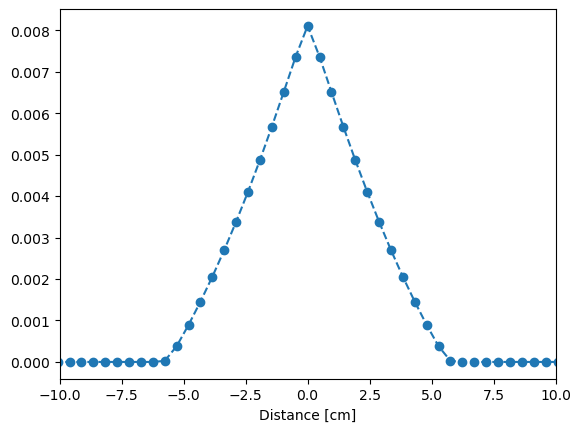

In [14]:
IDX = 100
plt.plot(x.cpu(), output128[IDX,64].detach().cpu(), 'o--')
plt.xlabel('Distance [cm]')
plt.xlim(-10,10)
plt.show()

Check normalization:

In [15]:
print(output128.sum(dim=(1,2)))

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 

We can save the operator as follows, and we can reopen later:

In [16]:
# change path
psf_operator.save(f'/disk1/psf_data/140kev_lehs.pkl')